In [1]:
import scanpy as sc

In [2]:
# 设置参数
sc.settings.verbosity = 4
sc.settings.set_figure_params(
    dpi=80,
    dpi_save=600,
    facecolor="white",
    frameon=False,  # remove frame
)

## 13.1 准备 monocle3

    - 花里胡哨，自带的去批次太差


In [ ]:
## 13.1.1 读取注释后的数据
# 读入数据
TABEL_DIR = "tables"
FIGURE_DIR = "figures"
ANNO_COL = "celltypist"
GROUPs_COL = "group"
ONLY_CELL = "Macrophages"
CTROL = "CCL"
STIM = "LCL"
adata = sc.read(
    "../../results/adata_raw_CCL_LCL/anndata_annotation_harmony_celltypist.h5ad"
)
adata

/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 71320 × 2000
    obs: 'C0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_antibody', 'nFeature_antibody', 'patients', 'sampletag', 'organs', 'percent.mt', 'percent.ribo', 'log10GenesPerUMI', 'batch', 'integrated_snn_res.0.5', 'seurat_clusters', 'samples', 'doublet.score', 'predicted.doublet', 'cluster', 'doublet', 'patients_organ', 'sample', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'discard', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_0_25', 'leiden_0_5', 'leiden_1', 'leiden_2', 'celltypist_cell_label_fine'

In [4]:
adata.obs.groupby(GROUPs_COL)[ANNO_COL].value_counts()

group  celltypist  
CCL    T cells         15091
       Macrophages      2901
       B cells          2316
       Plasma cells     1757
       Mast cells        742
       DC                263
       ILC               162
       pDC               132
LCL    T cells         42664
       Macrophages      2209
       B cells          1410
       ILC               407
       DC                369
       Plasma cells      366
       Mast cells        267
       pDC               264
Name: celltypist, dtype: int64

In [5]:
adata = adata[adata.obs.group == STIM]
adata = adata[adata.obs[ANNO_COL] == ONLY_CELL]
adata = adata.raw.to_adata().copy()
adata

AnnData object with n_obs × n_vars = 2209 × 17063
    obs: 'C0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_antibody', 'nFeature_antibody', 'patients', 'sampletag', 'organs', 'percent.mt', 'percent.ribo', 'log10GenesPerUMI', 'batch', 'integrated_snn_res.0.5', 'seurat_clusters', 'samples', 'doublet.score', 'predicted.doublet', 'cluster', 'doublet', 'patients_organ', 'sample', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'discard', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_0_25', 'leiden_0_5', 'leiden_1', 'leiden_2', 'celltypist_cell_label_fine'

In [6]:
## 13.1.2 准备R环境
import numpy as np
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri


%load_ext rpy2.ipython 

In [7]:
numpy2ri.activate()
pandas2ri.activate()  # type: ignore

In [8]:
## 13.2 准备变量
expression_matrix = adata.X.T
cell_metadata = adata.obs
gene_annotation = adata.var

In [9]:
expression_matrix

<17063x2209 sparse matrix of type '<class 'numpy.float64'>'
	with 2748918 stored elements in Compressed Sparse Row format>

In [10]:
adata

AnnData object with n_obs × n_vars = 2209 × 17063
    obs: 'C0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_antibody', 'nFeature_antibody', 'patients', 'sampletag', 'organs', 'percent.mt', 'percent.ribo', 'log10GenesPerUMI', 'batch', 'integrated_snn_res.0.5', 'seurat_clusters', 'samples', 'doublet.score', 'predicted.doublet', 'cluster', 'doublet', 'patients_organ', 'sample', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'discard', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_0_25', 'leiden_0_5', 'leiden_1', 'leiden_2', 'celltypist_cell_label_fine'

In [11]:
import scipy.sparse


def convert_csr_to_dense(matrix):
    """
    检查输入是否为 CSR 矩阵，并在需要时将其转换为密集矩阵。

    参数:
    matrix (scipy.sparse.csr_matrix or any): 要转换的矩阵。

    返回:
    numpy.ndarray or any: 转换后的密集矩阵或原始输入。
    """
    if isinstance(matrix, scipy.sparse.csr_matrix):
        # 将 CSR 矩阵转换为密集矩阵
        return matrix.toarray()
    else:
        # 如果不是 CSR 矩阵，返回原始输入
        return matrix.toarray()

In [12]:
expression_matrix = convert_csr_to_dense(expression_matrix)

In [13]:
# %pip install pandas==1.5.3

In [14]:
%%R -i expression_matrix -i cell_metadata -i gene_annotation

## 13.3 从R中构建cds对象
library(monocle3)
# 必须要一列名为gene_short_name
gene_annotation$gene_short_name = rownames(gene_annotation)
expression_matrix = as.matrix(expression_matrix)
cds <- new_cell_data_set(
    expression_matrix,
    cell_metadata = cell_metadata,
    gene_metadata = gene_annotation
                         )

/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
R[write to console]: Loading required package: Biobase

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unso

In [15]:
%%R
# colnames(cds) = colData(cds)$C0
cds

class: cell_data_set 
dim: 17063 2209 
metadata(1): cds_version
assays(1): counts
rownames(17063): A1BG A1CF ... ZYX ZZEF1
rowData names(11): mt ribo ... n_cells gene_short_name
colnames(2209): 1339 1382 ... 190158 190298
colData names(56): C0 orig.ident ... celltypist Size_Factor
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [16]:
# %%R
# ## 13.4预处理数据
# cds <- preprocess_cds(cds, num_dim = 50)
# cds <- align_cds(cds, alignment_group = "orig.ident")
# plot_pc_variance_explained(cds)

In [17]:
# %%R
# ## 13.5降维、可视化
# cds <- reduce_dimension(
#     cds,
#     reduction_method = c("Aligned"),
#     # 总之得先指定UMAP
#     cores=20,# 用多少核心
#     )
# plot_cells(cds, label_groups_by_cluster=FALSE,  color_cells_by = "leiden")

In [16]:
int_embed = adata.obsm["X_umap"]

In [17]:
%%R -i int_embed

## 使用scanpy降维结果
cds@int_colData$reducedDims$UMAP <- int_embed#赋值

R[write to console]: No trajectory to plot. Has learn_graph() been called yet?



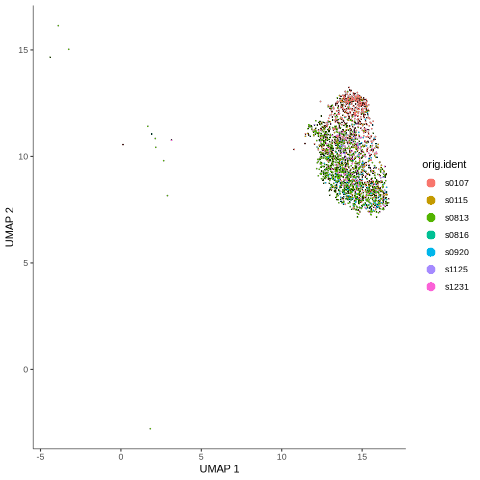

In [18]:
%%R
names(colData(cds))
## 13.4.1 检查批次效应
plot_cells(cds, color_cells_by="orig.ident", label_cell_groups=FALSE)

In [21]:
%%R
## 13.6 可视化单个基因如何沿着轨迹变化
# ciliated_genes <- c("TFF3", "CCL21", "PDPN")

# plot_cells(cds,
#            genes=ciliated_genes,
#            label_cell_groups=FALSE,
#            show_trajectory_graph=FALSE)

NULL


R[write to console]: set_nn_control: call stack: () => () => () => withVisible() => cluster_cells() => set_nn_control()

R[write to console]:   nn_control: 

R[write to console]:     method: annoy

R[write to console]:     metric: euclidean

R[write to console]:     n_trees: 50

R[write to console]:     search_k: 2000

R[write to console]:     cores: 1

R[write to console]:     grain_size: 1

R[write to console]: Running leiden clustering algorithm ...

R[write to console]: Run kNN based graph clustering starts:
  -Input data of 2209 rows and 2 columns
  -k is set to 20

R[write to console]:   Finding nearest neighbors...

R[write to console]: set_nn_control: call stack: () => () => () => withVisible() => cluster_cells() => leiden_clustering() => cluster_cells_make_graph() => make_nn_index() => set_nn_control()

R[write to console]:   nn_control: 

R[write to console]:     method: annoy

R[write to console]:     metric: euclidean

R[write to console]:     n_trees: 50

R[write to consol

   resolution_parameter  quality modularity significance cluster_count selected
                  1e-04 87872.25          0            0             1        *


R[write to console]: 

R[write to console]:   Cell counts by cluster



   cluster cell_count cell_fraction
         1       2209         1.000


R[write to console]: 

R[write to console]:   Maximal modularity is 0 for resolution parameter 1e-04

R[write to console]: 
  Run kNN based graph clustering DONE.
  -Number of clusters: 1

R[write to console]: No trajectory to plot. Has learn_graph() been called yet?



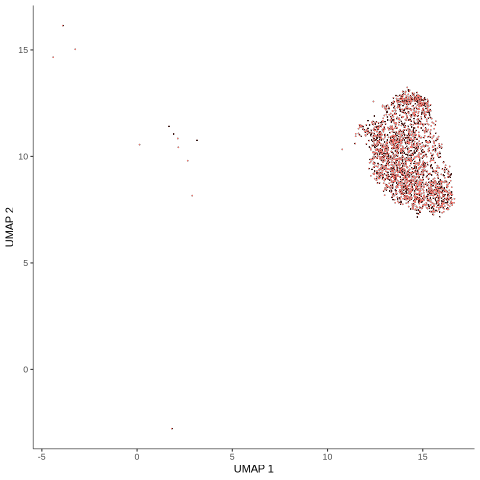

In [19]:
%%R
## 13.7 聚集细胞轨迹
cds <- cluster_cells(
    cds,
    verbose = TRUE
    ) 
plot_cells(cds, color_cells_by = "cluster", group_cells_by="partition")

  |======================================================================| 100%


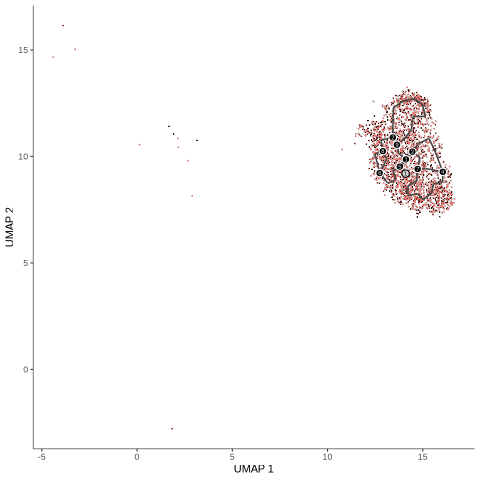

In [20]:
%%R
## 13.8 学习轨迹

cds <- learn_graph(
    cds, 
    # use_partition = F # 不使用聚类结果,如果大多是灰的话
)
plot_cells(
    cds,
    color_cells_by = "cluster",
    label_groups_by_cluster=T,
    label_leaves=T,
    label_branch_points=T
    )

computing Diffusion Maps using n_comps=15(=n_dcs)
        initialized `.distances` `.connectivities` `.eigen_values` `.eigen_basis` `.distances_dpt`
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [ 1.          1.          0.994837    0.97796494  0.965658    0.96356523
      0.9559375   0.9387097   0.93654186  0.9325425   0.9273133   0.92266655
      0.9197336  -0.96576107 -1.        ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:01:52)


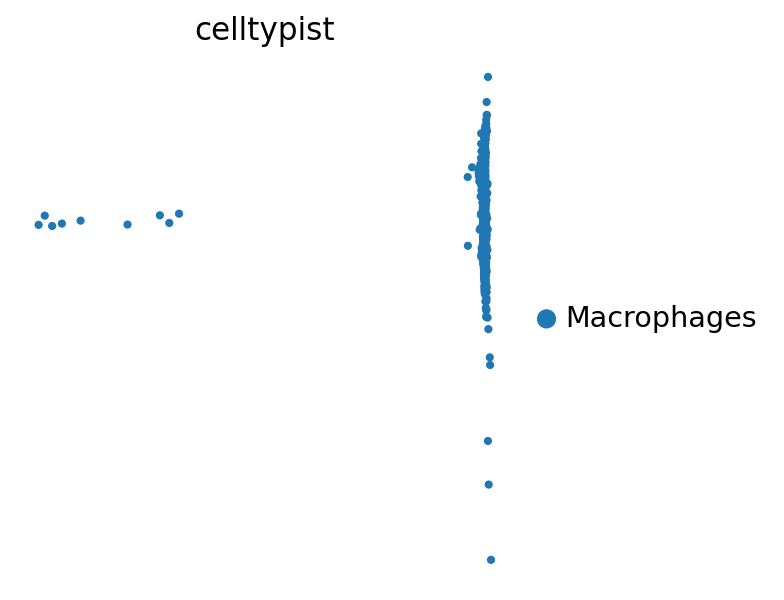

321 64303


In [ ]:
##  计算扩散伪时间（DPT）-我是为了找出根节点
sc.tl.diffmap(adata, random_state=123)
# Setting root cell as described above
root_ixs = adata.obsm["X_diffmap"][:, 3].argmin()


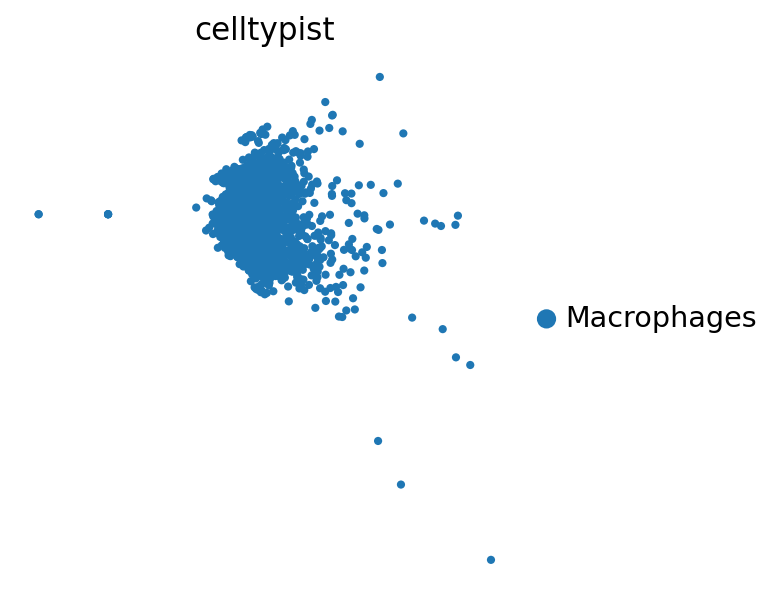

325 64328


In [29]:
sc.pl.scatter(
    adata,
    basis="diffmap",
    color=ANNO_COL,
    components=[1,3],
)

adata.uns["iroot"] = root_ixs
# 为了传给R,root_ixs是索引需要+1
root_ixs = root_ixs + 1
print(root_ixs, adata.obs_names[root_ixs])

In [ ]:
# %%# 导入modin.pandas，它是pandas的加速版，可以在分布式系统中更快地处理数据
# import modin.pandas as pd
# # 导入os模块来设置环境变量
# import os

# # 设置Modin使用Dask引擎，Dask支持并行计算，可以提高处理速度
# os.environ["MODIN_ENGINE"] = "dask"  # Modin将使用Dask

# # 读取表达矩阵文件
# expr_matrix = pd.read_csv(
#     "data/raw/GSM7058754/une_counts.txt",  # 文件路径
#     header=0,  # 假设第一行是标题
#     index_col=0,  # 使用第一列作为索引
#     engine='c',  # 使用C引擎，它比python引擎快
#     sep='\t'  # 字段之间使用制表符分隔
# )

In [ ]:
%%R
#TODO 还没用
    ## 定义函数 get_earliest_principal_node ：根据指定的细胞类型（celltype）名称，找到Seurat对象中对应细胞的主成分图（UMAP）上的最近顶点
get_earliest_principal_node <- function(cds, time_bin=c('DEGC')){
      # 首先找到指定celltype的 ID
      cell_ids <- which(colData(cds)[, "celltype"] == time_bin)
      # 获取主成分图（UMAP）中细胞投影到最近分支结点的信息
      closest_vertex <- cds@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
      closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
      # 找到在指定的celltype出现次数最多的分支节点
      root_pr_nodes <- igraph::V(principal_graph(cds)[["UMAP"]])$name[as.numeric(names(which.max(table(closest_vertex[cell_ids,]))))] # igraph::V()函数获取主成分图中的所有顶点信息
      root_pr_nodes
    }


In [32]:
%%R -i root_ixs
cds <- order_cells(
  cds,
  reduction_method = "UMAP",
#   root_pr_nodes = "Y_1",
  root_cells = colnames(cds)[root_ixs],
  verbose = True
)

cds$pseudotime <- cds@principal_graph_aux[["UMAP"]]$pseudotime[colnames(cds)]

In [26]:
%%R
## 13.9 伪时间排序

# # 最好是上游提供"embryo.time.bin"
# plot_cells(
#     cds,
#     color_cells_by = "embryo.time.bin", 
#     label_cell_groups=FALSE,
#     label_leaves=TRUE,
#     label_branch_points=TRUE,
#     graph_label_size=1.5
#     )

NULL


In [ ]:
%%R 
library(ggplot2)
plot_cells(
    cds,
    color_cells_by = "pseudotime",
    label_cell_groups=FALSE,
    label_leaves=FALSE,
    label_branch_points=FALSE,
    graph_label_size=1.5
    )

ggsave("figures/08-monocle3-拟时序分化轨迹图.pdf")

R[write to console]: Want to understand how all the pieces fit together? Read R for Data
Science: https://r4ds.hadley.nz/



Cannot find directory 'figures'.
ℹ Would you like to create a new directory?

1: Yes
2: No

✔ Created directory: 'figures'.
Saving 6.67 x 6.67 in image


In [ ]:
# %%R
# ## 一种自动找根节点的方法
# # a helper function to identify the root principal points:
# get_earliest_principal_node <- function(cds, time_bin="(4.34,8.68]"){
#   cell_ids <- which(colData(cds)[, "embryo.time.bin"] == time_bin)

#   closest_vertex <-cds@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
#   closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
#   root_pr_nodes <-
#   igraph::V(principal_graph(cds)[["UMAP"]])$name[as.numeric(names
#   (which.max(table(closest_vertex[cell_ids,]))))]

#   root_pr_nodes
# }
# cds <- order_cells(cds, root_pr_nodes=get_earliest_principal_node(cds, time_bin="(39.1,43.5]"))

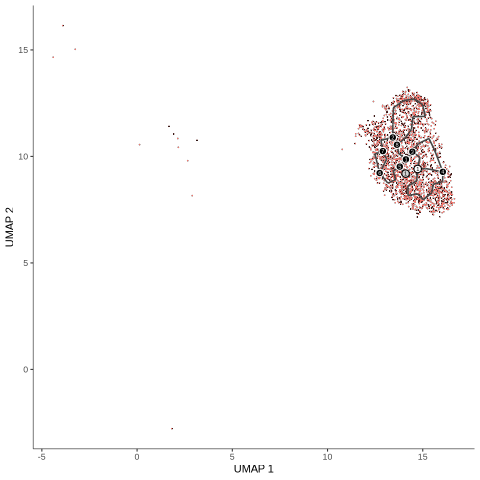

In [35]:
%%R
plot_cells(cds, label_groups_by_cluster=FALSE)


- 图形自相关分析

In [36]:
%%R 
## 图形自相关分析

## 深入分析，选择单个分支比较快，这里选择整个图
subset_pr_test_res <- graph_test(cds, neighbor_graph="principal_graph", cores=20)
# 轨迹上附近位置的细胞对于被测试基因的表达水平是否相似（或不同
##morans_I（空间共表达）,其数值越靠近1代表这个基因在空间距离相近的细胞中表达值越相似，0则代表没有空间共表达效应
# subset_pr_test_res = subset(subset_pr_test_res, q_value < 0.05)
subset_pr_test_res |> write.csv("")

str(subset_pr_test_res)

  |=======================================================| 100%, Elapsed 02:13
'data.frame':	17063 obs. of  16 variables:
 $ status               : chr  "OK" "OK" "OK" "OK" ...
 $ p_value              : num  4.54e-01 5.88e-01 7.29e-73 8.05e-01 1.61e-06 ...
 $ morans_test_statistic: num  0.115 -0.223 18.016 -0.859 4.656 ...
 $ morans_I             : num  0.000257 -0.001553 0.111108 -0.000545 0.022813 ...
 $ mt                   : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ ribo                 : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ hb                   : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ n_cells_by_counts    : int  4374 62 3752 23 317 4086 1425 13 4259 11791 ...
 $ mean_counts          : num  0.051171 0.00065 0.129436 0.000241 0.004023 ...
 $ log1p_mean_counts    : num  0.049905 0.000649 0.121718 0.000241 0.004015 ...
 $ pct_dropout_by_counts: num  95.4 99.9 96.1 100 99.7 ...
 $ total_counts         : num  4884 62 12354 23 384 ...
 $ log1p_total_counts  

In [33]:
# %%R
# moransg <- row.names(subset(ciliated_cds_pr_test_res, q_value < 0.05))
# gene_module_df <- find_gene_modules(cds[moransg,], resolution=c(10 ^ seq(-6, -1)))

# cell_group_df <- tibble::tibble(cell=row.names(colData(cds)), 
#                                 cell_group=colData(cds)$cell.type)
# agg_mat <- aggregate_gene_expression(cds, gene_module_df, cell_group_df)
# row.names(agg_mat) <- stringr::str_c("Module ", row.names(agg_mat))
# pheatmap::pheatmap(agg_mat,
#                    scale="column", clustering_method="ward.D2")

In [37]:
%%R
library(dplyr)
library(ggplot2)
## 下面我们进行绘制单个基因在不同亚群之间的表达量变化
# 可以指定感兴趣的基因
# 这里就按照morans_I选择前十个基因

top10 <- subset_pr_test_res |> 
    subset(q_value < 0.05) |> 
    top_n(n=12, morans_I) |>
    pull(gene_short_name) |> 
    as.character()
## 来自基因优先级
# top10 = c('Fez2', 'Fez1', 'Atp2a2', 'Atp6v1a', 'Gabarap', 'Kdr') 
# ['Fez2', 'Fez1', 'Atp2a2', 'Atp6v1a', 'Gabarap', 'Kdr']
top10 = top10[top10 %in% rownames(cds)]
top10

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


R[write to console]: The following object is masked from ‘package:GenomeInfoDb’:

    intersect


R[write to console]: The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


R[write to console]: The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


R[write to console]: The following object is masked from ‘package:matrixStats’:

    count


R[write to console]: The following object is masked from ‘package:Biobase’:

    combine


R[write to console]: The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from

 [1] "BAG3"     "CD74"     "DNAJB1"   "HLA-DPA1" "HLA-DRB1" "HSP90AA1"
 [7] "HSPA1A"   "HSPA1B"   "HSPA6"    "HSPH1"    "IL1B"     "PLAUR"   


In [41]:
%%R
cds

class: cell_data_set 
dim: 17063 2209 
metadata(2): cds_version citations
assays(1): counts
rownames(17063): A1BG A1CF ... ZYX ZZEF1
rowData names(11): mt ribo ... n_cells gene_short_name
colnames(2209): 1339 1382 ... 190158 190298
colData names(57): C0 orig.ident ... Size_Factor pseudotime
reducedDimNames(1): UMAP
mainExpName: NULL
altExpNames(0):


In [48]:
%%R
sce = cds[top10]

gene_names <- rownames(sce)

# Replace '-' with '_'
gene_names <- gsub("-", "_", gene_names)

# Assign the modified gene names back to the rownames
rownames(sce) <- gene_names


In [ ]:
%%R
## 13.11 基因表达时间序列图
p1 = plot_genes_in_pseudotime(
   sce, 
    color_cells_by="pseudotime", 
    min_expr=0.5, 
    ncol = 3
    )
ggsave("figures/08-monocle3-基因表达时间序列图.pdf",p1, width = 14, height = 8)
p1

R[write to console]: Error in plot_genes_in_pseudotime(sce, genes = gene_names, color_cells_by = "pseudotime",  : 
  unused argument (genes = gene_names)




Error in plot_genes_in_pseudotime(sce, genes = gene_names, color_cells_by = "pseudotime",  : 
  unused argument (genes = gene_names)


RInterpreterError: Failed to parse and evaluate line '## 13.11 基因表达时间序列图\np1 = plot_genes_in_pseudotime(\n   sce, \n    genes=gene_names,\n    color_cells_by="pseudotime", \n    min_expr=0.5, \n    ncol = 3\n    )\nggsave("figures/08-monocle3-基因表达时间序列图.pdf",p1, width = 14, height = 8)\np1\n'.
R error message: 'Error in plot_genes_in_pseudotime(sce, genes = gene_names, color_cells_by = "pseudotime",  : \n  unused argument (genes = gene_names)'

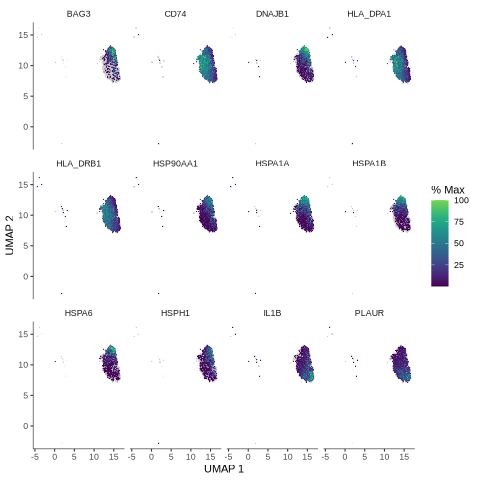

In [52]:
%%R
#基因特征图
p2 = plot_cells(sce, genes=gene_names, show_trajectory_graph=FALSE,label_cell_groups=FALSE,  label_leaves=FALSE)
ggsave("figures/08-monocle3-基因表达聚类图.pdf",p2, width = 17, height = 10)
p2

- 回归分析


In [ ]:
# %%R 

# ciliated_genes <- top10
# cds_subset <- cds[rowData(cds)$gene_short_name %in% ciliated_genes,]
# cds_subset

class: cell_data_set 
dim: 12 3237 
metadata(2): cds_version citations
assays(1): counts
rownames(12): APOC1 APOE ... HSPH1 SPP1
rowData names(11): mt ribo ... n_cells gene_short_name
colnames(3237): 1987 2241 ... 175251 175257
colData names(62): C0 orig.ident ... Size_Factor pseudotime
reducedDimNames(1): UMAP
mainExpName: NULL
altExpNames(0):


In [ ]:
# %%R 
# fit = fit_models(cds_subset, model_formula_str="~pseudotime+batch")
# fit_coefs <- coefficient_table(fit)
# emb_time_terms <- fit_coefs %>% 
#     filter(term == "pseudotime") %>% 
#     filter(term != "(Intercept)")
# emb_time_terms %>% filter (q_value < 0.05) %>%
#          select(gene_short_name, term, q_value, estimate)

# A tibble: 12 × 4
   gene_short_name term         q_value estimate
   <chr>           <chr>          <dbl>    <dbl>
 1 APOC1           pseudotime 4.40e-114   0.388 
 2 APOE            pseudotime 5.13e- 77   0.331 
 3 BAG3            pseudotime 5.72e- 25   0.204 
 4 C1QA            pseudotime 2.08e- 12   0.116 
 5 C1QB            pseudotime 9.13e- 11   0.122 
 6 C1QC            pseudotime 2.14e-  2   0.0413
 7 CTSD            pseudotime 2.26e- 70   0.267 
 8 DNAJA4          pseudotime 8.80e- 13   0.182 
 9 GPNMB           pseudotime 9.37e- 86   0.336 
10 HSPA6           pseudotime 5.85e- 32   0.221 
11 HSPH1           pseudotime 4.67e- 20   0.187 
12 SPP1            pseudotime 7.78e- 26   0.287 


In [ ]:
# %%R
# evaluate_fits(fit)
# # plot_genes_violin(cds_subset, group_cells_by = "pseudotime", ncol = 2) +
# #     theme(axis.text.x = element_text(angle = 45, hjust = 1))

# # plot_genes_hybrid(cds_subset, group_cells_by = "pseudotime", ncol = 2) +
# #     theme(axis.text.x = element_text(angle = 45, hjust = 1))

# A tibble: 12 × 21
   mt    ribo  hb    n_cells_by_counts mean_counts log1p_mean_counts
   <lgl> <lgl> <lgl>             <int>       <dbl>             <dbl>
 1 FALSE FALSE FALSE              7700       0.467             0.383
 2 FALSE FALSE FALSE              6784       0.351             0.301
 3 FALSE FALSE FALSE             21375       0.435             0.361
 4 FALSE FALSE FALSE             10006       0.428             0.356
 5 FALSE FALSE FALSE             10157       0.638             0.493
 6 FALSE FALSE FALSE             10081       0.622             0.483
 7 FALSE FALSE FALSE             41132       0.661             0.507
 8 FALSE FALSE FALSE             15050       0.179             0.165
 9 FALSE FALSE FALSE              6391       0.221             0.199
10 FALSE FALSE FALSE             31369       1.31              0.836
11 FALSE FALSE FALSE             65427       1.52              0.926
12 FALSE FALSE FALSE              6197       0.622             0.484
# ℹ 15 more va

- 评估基因表达模型
表达式_系列	分配	准确性	速度	笔记

quasipoisson	拟泊松	++  	++	默认为fit_models()。推荐给大多数用户。

negbinomial	负二项式	+++	  +	推荐给拥有较小数据集（少于 1,000 个单元格）的用户。

poisson	泊松	-	  +++	不推荐。仅用于调试和测试。

binomial	二项式	++	  ++	推荐用于单细胞 ATAC-seq

In [ ]:
# %%R -o pseudotime

# pseudotime <- colData(cds)$pseudotime

In [ ]:
# adata.obs["pseudotime"] = pseudotime  # type: ignore
# adata.write("anndata_monocle3.h5ad")  # type: ignore

In [ ]:
# %%R
# saveRDS(cds, "cds.rds")   